1.0
0.8999999981283064 -1.8716935779039545e-09
0.9 9.000000000000002
0.07927768122105246


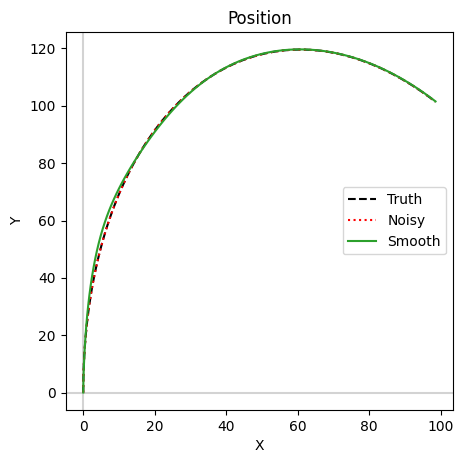

1.24033247861512


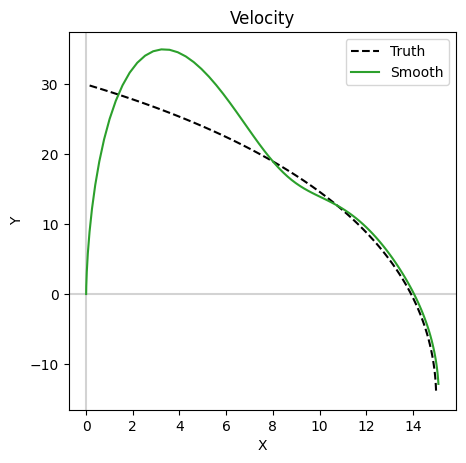

16.554375596230575


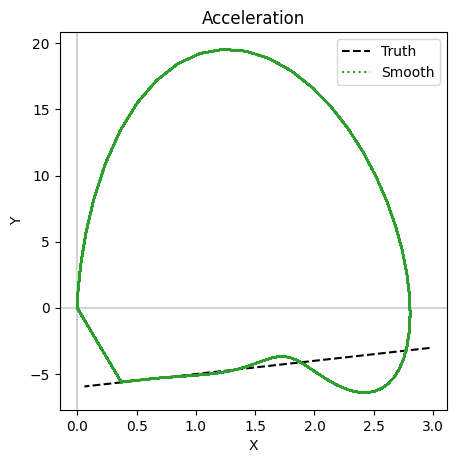

5.0
0.5904624089555435 -2.7591044456598546e-05
0.9 9.000000000000002
1.7946317252549082


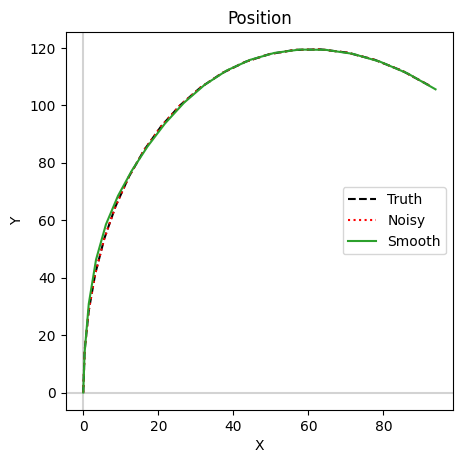

0.46466946989635716


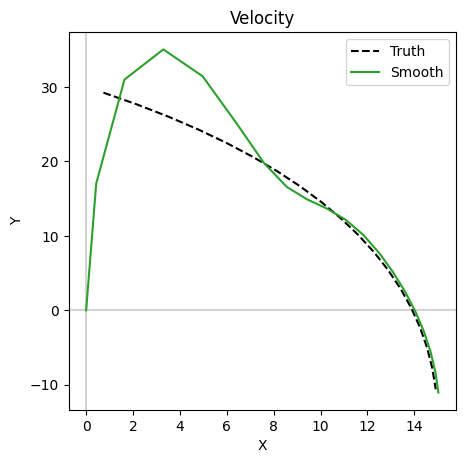

15.66398800269517


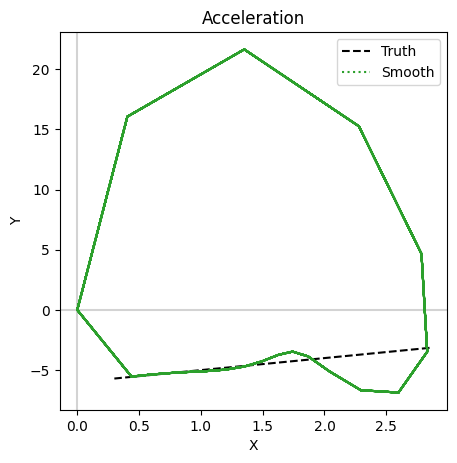

0.09999999999999999
0.9895192582062124 -1.9984014443252818e-15
0.9 9.000000000000002
0.500143719521235


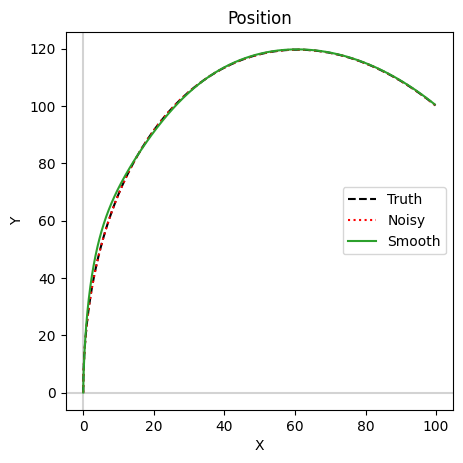

1.649848336437812


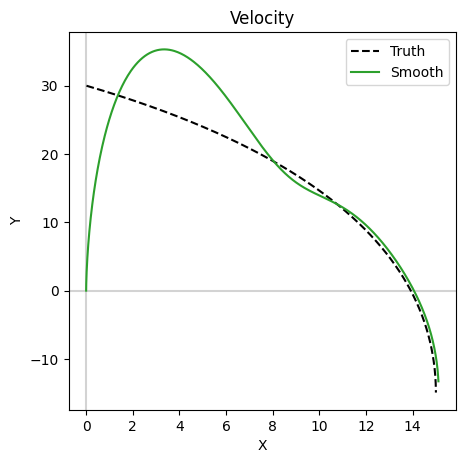

16.760284159943794


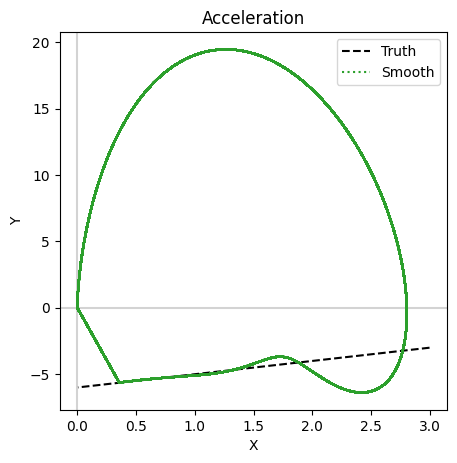

In [23]:
from typing import List
from shared import Vec2
import matplotlib.pyplot as plt
import numpy as np

figsize=(5, 5)
dpi = 100.

delta = 0.1

t = 0.1
# t = 0.03
# t = 0.3

def bezier(start: Vec2, end: Vec2, c1: Vec2, c2: Vec2, samples: int) -> List[Vec2]:
    points: List[Vec2] = []
    for i in range(samples):
        t = i / samples
        s = 1.0 - t
        points.append(
            s ** 3 * start + 3 * s ** 2 * t * c1 + 3 * s * t ** 2 * c2 + t ** 3 * p2
        )
    return points


def draw_path(path: List[Vec2], style: str = ".-k", label: str = None, *, plot=None):
    _path = np.array(path)
    xpath = _path[:, 0]
    ypath = _path[:, 1]

    if plot is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        plot = fig.add_subplot()
        plot.axhline(0, color='lightgrey')
        plot.axvline(0, color='lightgrey')
        plot.set_ylabel('Y')
        plot.set_xlabel('X')
    plot.plot(xpath, ypath, style, label=label)
    return plot

def draw_line(path: List[float], style: str = ".-k", label: str = None, *, plot=None):
    xpath = np.array(path)

    if plot is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        plot = fig.add_subplot()
        plot.set_xlabel('Time')
    plot.plot(xpath, style, label=label)
    return plot


def velocity(path: List[Vec2]):
    v = [Vec2(0, 0)]
    for i in range(len(path) - 1):
        v.append((path[i + 1] - path[i])/t)
    return v


def noisy(path: List[Vec2], scale: float = 1):
    noise = np.random.normal(loc=0, scale=scale, size=(len(path), 2))
    return [(p + n).view(Vec2) for p, n in zip(path, noise)]

class Motion:
    def __init__(self):
        self.p: List[Vec2] = None
        self.v: List[Vec2] = None
        self.a: List[Vec2] = None

def smooth(path: List[Vec2], k: float = 0.85, out=''):
    lnk = np.log(k)

    p = [path[0]] + [None] * (len(path) - 1)
    v = [Vec2(0, 0)] + [None] * (len(path) - 1)
    a = [Vec2(0, 0)] + [None] * (len(path) - 1)

    # Taylor series for e ** x
    t2 = 0.5 * t * t
    n = t / delta
    x = n * lnk
    x2 = x * x
    x3 = x2 * x
    x4 = x2 * x2
    x5 = x2 * x3 
    k_ = 1 + x + x2 / 2 + x3 / 6 + x4 / 24 + x5 / 120
    # END Taylor series for e ** x

    print(k_, k_ - k**n)

    # k_ = k

    for i in range(1, len(path)):
        observed = path[i]


        p_pred = p[i - 1] + v[i - 1] * n + 0.5 * a[i - 1] * n * n
        v_pred = v[i - 1] + a[i - 1] * n

        p[i] = p_pred + (1 - k_) * (observed - p_pred)
        v[i] = k_ * v_pred + (1 - k_) * (p[i] - p_pred) / n
        a[i] = k_ * a[i - 1] + (1 - k_) * (v[i] - v_pred) / n
        
    k_correction = 0
    k_correction = k/(1-k) 

    print(k, k_correction)

    m = Motion()
    m.p = [p_ + v_ * k_correction + a_ * k_correction * k_correction for p_, v_, a_ in zip(p, v, a)]
    m.v = [2 / delta * (v_ + a_ * k_correction) for v_, a_ in zip(v, a)]
    m.a = [4 / delta / delta * (a_) for a_, in zip(a)] * len(m.p) 
    return m

def __sq_mag(v: Vec2):
    return v.dot(v)

sq_mag = np.vectorize(__sq_mag, signature='(v)->()')


p1 = Vec2(0, 0)
p2 = Vec2(100, 100)
c1 = Vec2(0, 100)
c2 = Vec2(50, 150)

path = None
noise = None

def gen(samples):
    global path
    global noise

    path = bezier(p1, p2, c1, c2, samples)
    # noise = noisy(path, 1)
    noise = path



def foo(k):
    print(t / delta)
    sm = smooth(noise, k)

    fig_path = draw_path(path, "--k", "Truth")
    draw_path(noise, ":r", "Noisy", plot=fig_path)
    draw_path(sm.p, "-C2", "Smooth", plot=fig_path)

    print(np.sqrt(sq_mag(path[-1] - sm.p[-1])))

    plt.title('Position')
    plt.legend()
    plt.show()


    fig_path = draw_path(velocity(path)[1:], "--k", "Truth")
    draw_path(sm.v, "-C2", "Smooth", plot=fig_path)

    print(np.sqrt(sq_mag(velocity(path)[-1] - sm.v[-1])))

    plt.title('Velocity')
    plt.legend()
    plt.show()

    fig_path = draw_path(velocity(velocity(path)[1:])[1:], "--k", "Truth")
    draw_path(sm.a, ":C2", "Smooth", plot=fig_path)

    print(np.sqrt(sq_mag(velocity(velocity(path))[-1] - sm.v[-1])))

    plt.title('Acceleration')
    plt.legend()
    plt.show()

t = .1
gen(100)
foo(.9)

t = .5
gen(20)
foo(.9)

t = .01
gen(1000)
foo(.9)